In [ ]:
from datetime import datetime
import IPython
import os
import pickle
import PIL
import pprint
import random

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import torch
import torchinfo
import torchvision
random.seed(3407)
np.random.seed(3407)
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
torch.backends.cudnn.benchmark = True  # ループ内で順伝播や逆伝播が同じ計算手法ならば処理を高速化させる

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**データ収集(今回はデータとして、HuggingFaceにある正解ラベル付きデータを使う)**

In [ ]:
# HuggingFaceにある犬猫写真分類の正解ラベル付きDatasetDictをロード
hugging_face_dataset_dict = datasets.load_dataset("cats_vs_dogs", trust_remote_code=True)
# ロードしたDatasetDictからDataset(DatasetDictにあるtrainのDatasetのみ)を取得
dataset = hugging_face_dataset_dict["train"]
# Datasetを確認
print(dataset)
# Dataset内のデータのタイプを確認
print(dataset.features)
# 一部のデータはRGB画像ではない(3階数テンソルではない)ので、そのデータを弾く
exclude_row_list = []
for i in range(dataset.num_rows):
    num_dim = len(np.array(dataset[i]["image"]).shape)  # 画像データのnumpyのテンソル階数を取得
    if num_dim != 3:
        exclude_row_list.append(i)  # RGB画像ではないデータの行番号を取得
print(exclude_row_list)
print("弾く前は", dataset.num_rows, "個")
include_row_list = [id for id in range(len(dataset)) if id not in exclude_row_list]  # RGB画像ではないデータの行番号を除いた行番号を取得
dataset = dataset.select(indices=include_row_list)
print("弾いた後は", dataset.num_rows, "個")
# Dataset内のデータをシャッフル
dataset_shuffle = dataset.shuffle()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'labels'],
    num_rows: 23410
})
{'image': Image(decode=True, id=None), 'labels': ClassLabel(names=['cat', 'dog'], id=None)}
[4376, 7237, 8915, 14892, 17021]
弾く前は 23410 個
弾いた後は 23405 個


In [ ]:
# Dataset内のデータを分割して、それぞれのDataset名がtrainとvalidationのDatasetDictにする
train_valid_dataset_dict = dataset_shuffle.train_test_split(test_size=0.2,
                                                            shuffle=True,
                                                            stratify_by_column="labels",  # stratify_by_columnに指定したカラムのデータが均等に分かれるように分割される
                                                            seed=42)
# Dataset名をtrainでなくvalidationにしたいので、Dataset名がtestになってしまったものを一旦取り出す
valid_dataset = train_valid_dataset_dict.pop("test")
# DatasetDictに改めてvalidationのDataset名で入れる
train_valid_dataset_dict["validation"] = valid_dataset

In [ ]:
train_valid_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 18724
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 4681
    })
})

**教師データを準備**

In [ ]:
num_train_data = train_valid_dataset_dict["train"].num_rows
num_valid_data = train_valid_dataset_dict["validation"].num_rows
# 全てのデータを使おうとするとCPUメモリが溢れるので、データの35%だけを使う
train_image_list = train_valid_dataset_dict["train"][:int(num_train_data*0.35)]["image"]
valid_image_list = train_valid_dataset_dict["validation"][:int(num_valid_data*0.35)]["image"]
train_label_list = train_valid_dataset_dict["train"][:int(num_train_data*0.35)]["labels"]
valid_label_list = train_valid_dataset_dict["validation"][:int(num_valid_data*0.35)]["labels"]

In [ ]:
print(len(train_image_list), len(valid_image_list))

**前処理(データ拡張含む)の準備**

In [ ]:
# データ拡張(Data Augmentation)を行うインスタンス
image_transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(224, 224)),  # 解像度を224×224に変換
                                                  torchvision.transforms.RandomHorizontalFlip(p=0.5)])  # 画像をランダムに左右反転

In [ ]:
# 正規化とテンソル化を行う関数
def normalize_and_tensorize(input_PIL_image):
    image_array = np.array(input_PIL_image)  # PIL画像をnumpyに変換
    image_array = image_array.transpose(2, 0, 1)  # (縦, 横, チャンネル)形状を機械学習向けの(チャンネル, 縦, 横)形状に変換
    normalized_image_array = image_array / 255  # RGBカラーなので255で割って正規化
    image_tensor = torch.FloatTensor(normalized_image_array)  # numpyをtensorに変換
    return image_tensor

**前処理(dataset化やdataloader化含む)**

In [ ]:
# Datasetクラスを作成
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, image_data_list, label_data_list, augmentation_method, tensorize_method):
        super().__init__()
        self.image_data_list = image_data_list
        self.label_data_list = label_data_list
        self.augmentation_method = augmentation_method
        self.tensorize_method = tensorize_method

    def __len__(self):
        return len(self.image_data_list)

    def __getitem__(self, idx):
        image = self.image_data_list[idx]
        augmentation_image = self.augmentation_method(image)  # PIL画像をData Augmentation
        augmentation_image_tensor = self.tensorize_method(input_PIL_image=augmentation_image)  # PIL画像を正規化＆テンソル化
        label = self.label_data_list[idx]
        return augmentation_image_tensor, label

In [ ]:
# train、validationデータをそれぞれdataset化
train_dataset = MyDataset(image_data_list=train_image_list,
                          label_data_list=train_label_list,
                          augmentation_method=image_transform,
                          tensorize_method=normalize_and_tensorize)
valid_dataset = MyDataset(image_data_list=valid_image_list,
                          label_data_list=valid_label_list,
                          augmentation_method=image_transform,
                          tensorize_method=normalize_and_tensorize)

In [ ]:
# train、validationデータのdatasetをそれぞれdataloader化
train_dataset_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                       batch_size=100,
                                                       shuffle=True)
valid_dataset_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                       batch_size=100,
                                                       shuffle=True)

**ResNet50モデルを作成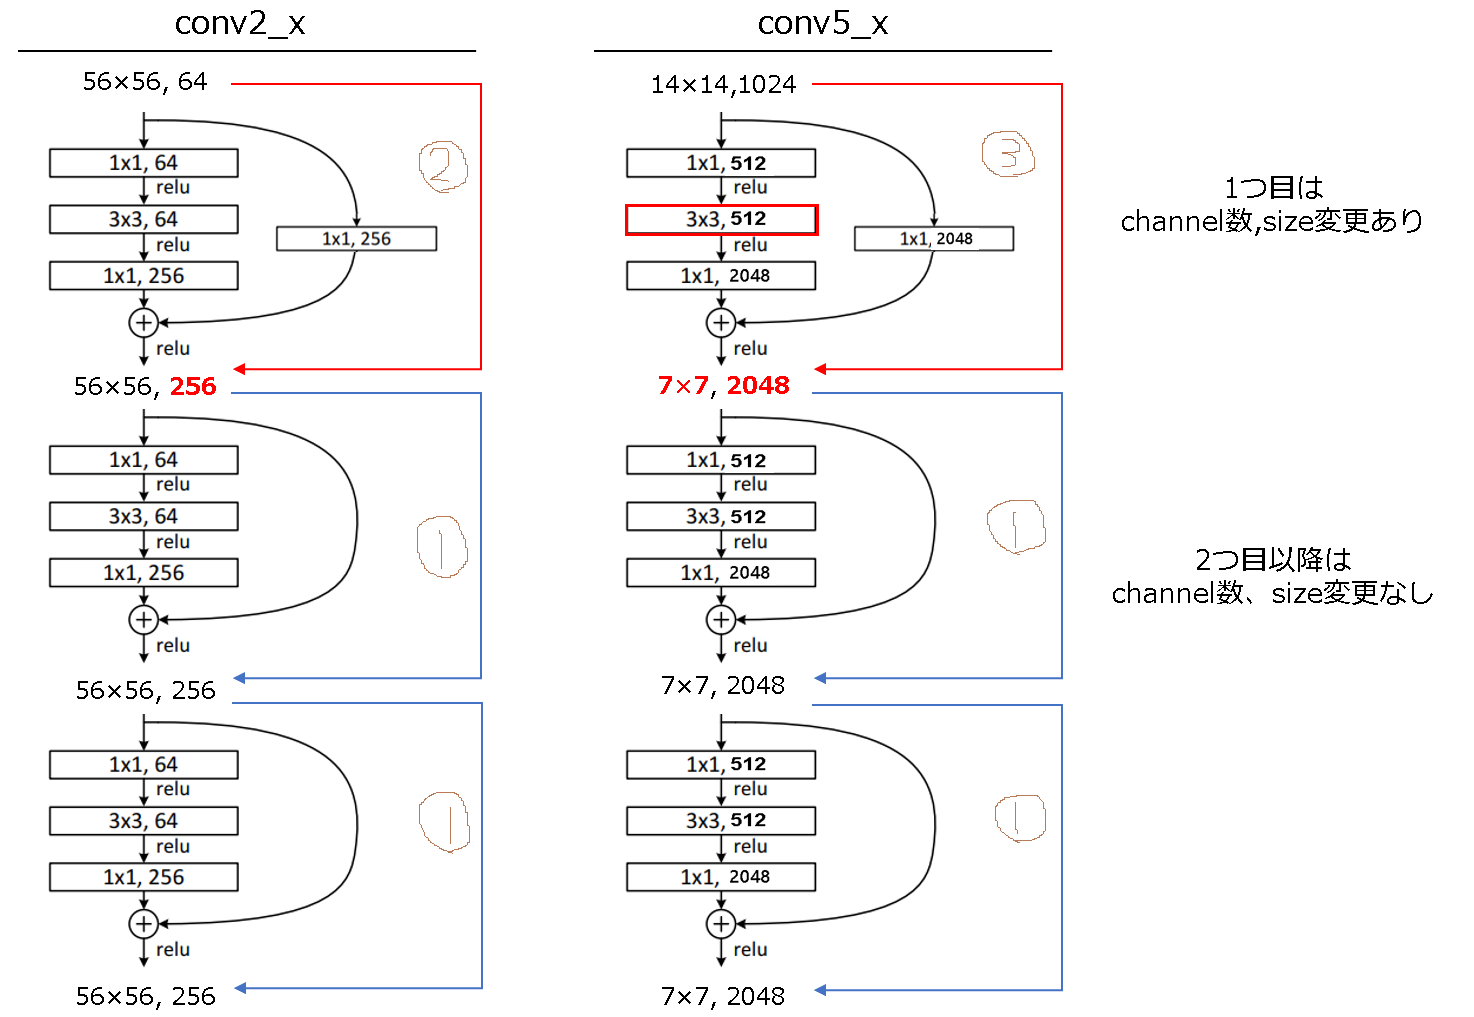**

In [ ]:
class MyResNet50ResidualBlock_1(torch.nn.Module):
    def __init__(self, in_data_channel):
        super().__init__()
        hidden_channel = int(in_data_channel / 4)  # intを付けないと割り算の結果が少数になってしまって、Conv2dの引数で使う時にエラーになる
        out_data_channel = in_data_channel
        self.layer_1_1 = torch.nn.Conv2d(in_channels=in_data_channel, out_channels=hidden_channel, kernel_size=1, stride=1, padding=0)
        self.layer_1_2 = torch.nn.BatchNorm2d(num_features=hidden_channel)
        self.layer_1_3 = torch.nn.ReLU()
        self.layer_2_1 = torch.nn.Conv2d(in_channels=hidden_channel, out_channels=hidden_channel, kernel_size=3, stride=1, padding=1)
        self.layer_2_2 = torch.nn.BatchNorm2d(num_features=hidden_channel)
        self.layer_2_3 = torch.nn.ReLU()
        self.layer_3_1 = torch.nn.Conv2d(in_channels=hidden_channel, out_channels=out_data_channel, kernel_size=1, stride=1, padding=0)
        self.layer_3_2 = torch.nn.BatchNorm2d(num_features=out_data_channel)
        self.layer_3_3 = torch.nn.ReLU()

    def forward(self, in_data):
        identity = in_data.clone()
        out_data_layer_1_1 = self.layer_1_1(in_data)
        out_data_layer_1_2 = self.layer_1_2(out_data_layer_1_1)
        out_data_layer_1_3 = self.layer_1_3(out_data_layer_1_2)
        out_data_layer_2_1 = self.layer_2_1(out_data_layer_1_3)
        out_data_layer_2_2 = self.layer_2_2(out_data_layer_2_1)
        out_data_layer_2_3 = self.layer_2_3(out_data_layer_2_2)
        out_data_layer_3_1 = self.layer_3_1(out_data_layer_2_3)
        out_data_layer_3_2 = self.layer_3_2(out_data_layer_3_1)
        in_data_layer_3_3 = out_data_layer_3_2 + identity
        out_data_layer_3_3 = self.layer_3_3(in_data_layer_3_3)
        return out_data_layer_3_3

In [ ]:
class MyResNet50ResidualBlock_2(torch.nn.Module):
    def __init__(self, in_data_channel):
        super().__init__()
        hidden_channel = in_data_channel
        out_data_channel = in_data_channel * 4
        self.layer_identity = torch.nn.Conv2d(in_channels=in_data_channel, out_channels=out_data_channel, kernel_size=1, stride=1, padding=0)
        self.layer_1_1 = torch.nn.Conv2d(in_channels=in_data_channel, out_channels=hidden_channel, kernel_size=1, stride=1, padding=0)
        self.layer_1_2 = torch.nn.BatchNorm2d(num_features=hidden_channel)
        self.layer_1_3 = torch.nn.ReLU()
        self.layer_2_1 = torch.nn.Conv2d(in_channels=hidden_channel, out_channels=hidden_channel, kernel_size=3, stride=1, padding=1)
        self.layer_2_2 = torch.nn.BatchNorm2d(num_features=hidden_channel)
        self.layer_2_3 = torch.nn.ReLU()
        self.layer_3_1 = torch.nn.Conv2d(in_channels=hidden_channel, out_channels=out_data_channel, kernel_size=1, stride=1, padding=0)
        self.layer_3_2 = torch.nn.BatchNorm2d(num_features=out_data_channel)
        self.layer_3_3 = torch.nn.ReLU()

    def forward(self, in_data):
        identity = in_data.clone()
        out_data_layer_identity = self.layer_identity(identity)
        out_data_layer_1_1 = self.layer_1_1(in_data)
        out_data_layer_1_2 = self.layer_1_2(out_data_layer_1_1)
        out_data_layer_1_3 = self.layer_1_3(out_data_layer_1_2)
        out_data_layer_2_1 = self.layer_2_1(out_data_layer_1_3)
        out_data_layer_2_2 = self.layer_2_2(out_data_layer_2_1)
        out_data_layer_2_3 = self.layer_2_3(out_data_layer_2_2)
        out_data_layer_3_1 = self.layer_3_1(out_data_layer_2_3)
        out_data_layer_3_2 = self.layer_3_2(out_data_layer_3_1)
        in_data_layer_3_3 = out_data_layer_3_2 + out_data_layer_identity
        out_data_layer_3_3 = self.layer_3_3(in_data_layer_3_3)
        return out_data_layer_3_3

In [ ]:
class MyResNet50ResidualBlock_3(torch.nn.Module):
    def __init__(self, in_data_channel):
        super().__init__()
        hidden_channel = int(in_data_channel / 2)  # intを付けないと割り算の結果が少数になってしまって、Conv2dの引数で使う時にエラーになる
        out_data_channel = in_data_channel * 2
        self.layer_identity = torch.nn.Conv2d(in_channels=in_data_channel, out_channels=out_data_channel, kernel_size=1, stride=2, padding=0)  # チャンネルを2倍、解像度を半分
        self.layer_1_1 = torch.nn.Conv2d(in_channels=in_data_channel, out_channels=hidden_channel, kernel_size=1, stride=1, padding=0)
        self.layer_1_2 = torch.nn.BatchNorm2d(num_features=hidden_channel)
        self.layer_1_3 = torch.nn.ReLU()
        self.layer_2_1 = torch.nn.Conv2d(in_channels=hidden_channel, out_channels=hidden_channel, kernel_size=3, stride=2, padding=1)
        self.layer_2_2 = torch.nn.BatchNorm2d(num_features=hidden_channel)
        self.layer_2_3 = torch.nn.ReLU()
        self.layer_3_1 = torch.nn.Conv2d(in_channels=hidden_channel, out_channels=out_data_channel, kernel_size=1, stride=1, padding=0)
        self.layer_3_2 = torch.nn.BatchNorm2d(num_features=out_data_channel)
        self.layer_3_3 = torch.nn.ReLU()

    def forward(self, in_data):
        identity = in_data.clone()
        out_data_layer_identity = self.layer_identity(identity)
        out_data_layer_1_1 = self.layer_1_1(in_data)
        out_data_layer_1_2 = self.layer_1_2(out_data_layer_1_1)
        out_data_layer_1_3 = self.layer_1_3(out_data_layer_1_2)
        out_data_layer_2_1 = self.layer_2_1(out_data_layer_1_3)
        out_data_layer_2_2 = self.layer_2_2(out_data_layer_2_1)
        out_data_layer_2_3 = self.layer_2_3(out_data_layer_2_2)
        out_data_layer_3_1 = self.layer_3_1(out_data_layer_2_3)
        out_data_layer_3_2 = self.layer_3_2(out_data_layer_3_1)
        in_data_layer_3_3 = out_data_layer_3_2 + out_data_layer_identity
        out_data_layer_3_3 = self.layer_3_3(in_data_layer_3_3)
        return out_data_layer_3_3

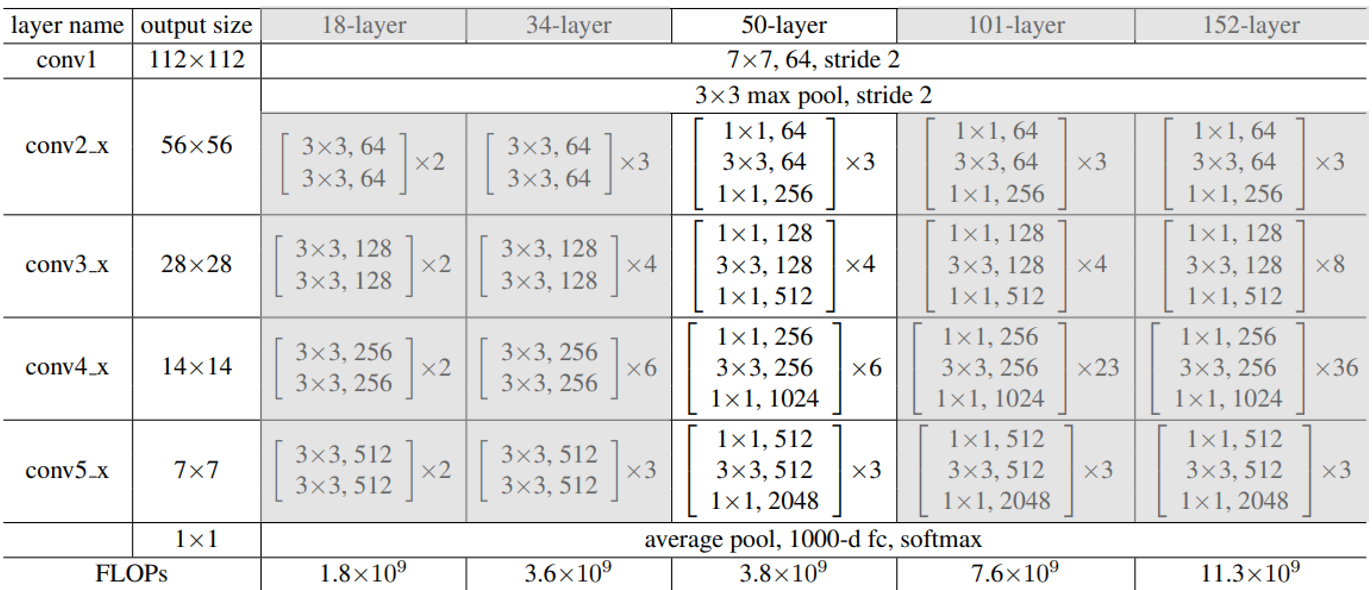

In [ ]:
class MyResNet50(torch.nn.Module):
    def __init__(self, in_dim, num_classification):
        super().__init__()
        self.layer_1a = torch.nn.Conv2d(in_channels=in_dim, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.layer_1b = torch.nn.BatchNorm2d(num_features=64)
        self.layer_1c = torch.nn.ReLU()
        self.layer_2a = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer_2b = MyResNet50ResidualBlock_2(in_data_channel=64)
        self.layer_2c = MyResNet50ResidualBlock_1(in_data_channel=256)
        self.layer_2d = MyResNet50ResidualBlock_1(in_data_channel=256)
        self.layer_3a = MyResNet50ResidualBlock_3(in_data_channel=256)
        self.layer_3b = MyResNet50ResidualBlock_1(in_data_channel=512)
        self.layer_3c = MyResNet50ResidualBlock_1(in_data_channel=512)
        self.layer_3d = MyResNet50ResidualBlock_1(in_data_channel=512)
        self.layer_4a = MyResNet50ResidualBlock_3(in_data_channel=512)
        self.layer_4b = MyResNet50ResidualBlock_1(in_data_channel=1024)
        self.layer_4c = MyResNet50ResidualBlock_1(in_data_channel=1024)
        self.layer_4d = MyResNet50ResidualBlock_1(in_data_channel=1024)
        self.layer_4e = MyResNet50ResidualBlock_1(in_data_channel=1024)
        self.layer_4f = MyResNet50ResidualBlock_1(in_data_channel=1024)
        self.layer_5a = MyResNet50ResidualBlock_3(in_data_channel=1024)
        self.layer_5b = MyResNet50ResidualBlock_1(in_data_channel=2048)
        self.layer_5c = MyResNet50ResidualBlock_1(in_data_channel=2048)
        self.layer_6 = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))  # 任意の解像度の入力に対して、指定した解像度を出力
        self.layer_7 = torch.nn.Linear(in_features=2048, out_features=num_classification)  # 6層と7層の間でreshapeを行って、(ミニバッチ数, 2048)の行列にする想定

    def forward(self, in_data):
        print("入力：", in_data.shape)  # (ミニバッチ数, チャンネル数, 縦, 横) # torch.Size([100, 3, 224, 224])
        out_data_layer_1a = self.layer_1a(in_data)
        print("1a：", out_data_layer_1a.shape)  # torch.Size([100, 64, 112, 112])
        out_data_layer_1b = self.layer_1b(out_data_layer_1a)
        out_data_layer_1c = self.layer_1c(out_data_layer_1b)
        out_data_layer_2a = self.layer_2a(out_data_layer_1c)
        print("2a：", out_data_layer_2a.shape)  # torch.Size([100, 64, 56, 56])
        out_data_layer_2b = self.layer_2b(out_data_layer_2a)
        print("2b：", out_data_layer_2b.shape)  # torch.Size([100, 256, 56, 56])
        out_data_layer_2c = self.layer_2c(out_data_layer_2b)
        print("2c：", out_data_layer_2c.shape)  # torch.Size([100, 256, 56, 56])
        out_data_layer_2d = self.layer_2d(out_data_layer_2c)
        print("2d：", out_data_layer_2d.shape)  # torch.Size([100, 256, 56, 56])
        out_data_layer_3a = self.layer_3a(out_data_layer_2d)
        print("3a：", out_data_layer_3a.shape)  # torch.Size([100, 512, 28, 28])
        out_data_layer_3b = self.layer_3b(out_data_layer_3a)
        print("3b：", out_data_layer_3b.shape)  # torch.Size([100, 512, 28, 28])
        out_data_layer_3c = self.layer_3c(out_data_layer_3b)
        print("3c：", out_data_layer_3c.shape)  # torch.Size([100, 512, 28, 28])
        out_data_layer_3d = self.layer_3d(out_data_layer_3c)
        print("3d：", out_data_layer_3d.shape)  # torch.Size([100, 512, 28, 28])
        out_data_layer_4a = self.layer_4a(out_data_layer_3d)
        print("4a：", out_data_layer_4a.shape)  # torch.Size([100, 1024, 14, 14])
        out_data_layer_4b = self.layer_4b(out_data_layer_4a)
        print("4b：", out_data_layer_4b.shape)  # torch.Size([100, 1024, 14, 14])
        out_data_layer_4c = self.layer_4c(out_data_layer_4b)
        print("4c：", out_data_layer_4c.shape)  # torch.Size([100, 1024, 14, 14])
        out_data_layer_4d = self.layer_4d(out_data_layer_4c)
        print("4d：", out_data_layer_4d.shape)  # torch.Size([100, 1024, 14, 14])
        out_data_layer_4e = self.layer_4e(out_data_layer_4d)
        print("4e：", out_data_layer_4e.shape)  # torch.Size([100, 1024, 14, 14])
        out_data_layer_4f = self.layer_4f(out_data_layer_4e)
        print("4f：", out_data_layer_4f.shape)  # torch.Size([100, 1024, 14, 14])
        out_data_layer_5a = self.layer_5a(out_data_layer_4f)
        print("5a：", out_data_layer_5a.shape)  # torch.Size([100, 2048, 7, 7])
        out_data_layer_5b = self.layer_5b(out_data_layer_5a)
        print("5b：", out_data_layer_5b.shape)  # torch.Size([100, 2048, 7, 7])
        out_data_layer_5c = self.layer_5c(out_data_layer_5b)
        print("5c：", out_data_layer_5c.shape)  # torch.Size([100, 2048, 7, 7])
        out_data_layer_6 = self.layer_6(out_data_layer_5c)
        print("6：", out_data_layer_6.shape)  # torch.Size([100, 2048, 1, 1])
        in_data_layer_7 = out_data_layer_6.reshape(out_data_layer_6.shape[0], -1)  # tensor.reshape(ミニバッチ数, -1)の形
        print("in7：", in_data_layer_7.shape)  # torch.Size([100, 2048])
        out_data_layer_7 = self.layer_7(in_data_layer_7)
        print("7：", out_data_layer_7.shape)  # torch.Size([100, 2])
        return out_data_layer_7

**モデル、損失関数、最適化アルゴリズム**

In [ ]:
nn_model = MyResNet50(in_dim=3, num_classification=2).to(device)  # GPUへ
loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

In [ ]:
torchinfo.summary(nn_model, input_size=(100, 3, 224, 224), depth=5)

入力： torch.Size([100, 3, 224, 224])
1a： torch.Size([100, 64, 112, 112])
2a： torch.Size([100, 64, 56, 56])
2b： torch.Size([100, 256, 56, 56])
2c： torch.Size([100, 256, 56, 56])
2d： torch.Size([100, 256, 56, 56])
3a： torch.Size([100, 512, 28, 28])
3b： torch.Size([100, 512, 28, 28])
3c： torch.Size([100, 512, 28, 28])
3d： torch.Size([100, 512, 28, 28])
4a： torch.Size([100, 1024, 14, 14])
4b： torch.Size([100, 1024, 14, 14])
4c： torch.Size([100, 1024, 14, 14])
4d： torch.Size([100, 1024, 14, 14])
4e： torch.Size([100, 1024, 14, 14])
4f： torch.Size([100, 1024, 14, 14])
5a： torch.Size([100, 2048, 7, 7])
5b： torch.Size([100, 2048, 7, 7])
5c： torch.Size([100, 2048, 7, 7])
6： torch.Size([100, 2048, 1, 1])
in7： torch.Size([100, 2048])
7： torch.Size([100, 2])


Layer (type:depth-idx)                   Output Shape              Param #
MyResNet50                               [100, 2]                  --
├─Conv2d: 1-1                            [100, 64, 112, 112]       9,472
├─BatchNorm2d: 1-2                       [100, 64, 112, 112]       128
├─ReLU: 1-3                              [100, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [100, 64, 56, 56]         --
├─MyResNet50ResidualBlock_2: 1-5         [100, 256, 56, 56]        --
│    └─Conv2d: 2-1                       [100, 256, 56, 56]        16,640
│    └─Conv2d: 2-2                       [100, 64, 56, 56]         4,160
│    └─BatchNorm2d: 2-3                  [100, 64, 56, 56]         128
│    └─ReLU: 2-4                         [100, 64, 56, 56]         --
│    └─Conv2d: 2-5                       [100, 64, 56, 56]         36,928
│    └─BatchNorm2d: 2-6                  [100, 64, 56, 56]         128
│    └─ReLU: 2-7                         [100, 64, 56, 56]         -

**学習と検証**

In [ ]:
if os.path.isfile("./epoch_train_loss_total_list.pkl"):
    with open("./epoch_train_loss_total_list.pkl", mode="rb") as f:
        epoch_train_loss_total_list = pickle.load(f)
else:
    epoch_train_loss_total_list = []
if os.path.isfile("./epoch_train_accuracy_rate_list.pkl"):
    with open("./epoch_train_accuracy_rate_list.pkl", mode="rb") as f:
        epoch_train_accuracy_rate_list = pickle.load(f)
else:
    epoch_train_accuracy_rate_list = []
if os.path.isfile("./epoch_valid_loss_total_list.pkl"):
    with open("./epoch_valid_loss_total_list.pkl", mode="rb") as f:
        epoch_valid_loss_total_list = pickle.load(f)
else:
    epoch_valid_loss_total_list = []
if os.path.isfile("./epoch_valid_accuracy_rate_list.pkl"):
    with open("./epoch_valid_accuracy_rate_list.pkl", mode="rb") as f:
        epoch_valid_accuracy_rate_list = pickle.load(f)
else:
    epoch_valid_accuracy_rate_list = []
if os.path.isfile("./FineTuning_ResNet50.model"):
    nn_model.load_state_dict(torch.load("./FineTuning_ResNet50.model"))
# エポック毎に学習と検証
for epoch in tqdm.notebook.tqdm(range(10)):
    # 学習
    print("train")
    nn_model.train()
    epoch_train_loss_total = 0
    train_data_num_total = 0
    train_accuracy_num_total = 0
    epoch_train_accuracy_rate = 0
    for train_image_tensor_minibatch, train_label_tensor_minibatch in train_dataset_dataloader:
        train_image_tensor_minibatch = train_image_tensor_minibatch.to(device)  # GPUへ
        train_label_tensor_minibatch = train_label_tensor_minibatch.to(device)  # GPUへ
        print("train画像：", train_image_tensor_minibatch.shape)
        print("train正解：", train_label_tensor_minibatch.shape)
        output = nn_model(in_data=train_image_tensor_minibatch)
        print("推測：", output.shape)
        loss = loss_f(output, train_label_tensor_minibatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss_total = epoch_train_loss_total + loss.item()
        output_softmax = torch.nn.functional.softmax(input=output, dim=1)
        output_softmax_argmax = torch.argmax(input=output_softmax, dim=1)
        train_data_num = len(train_label_tensor_minibatch)
        train_data_num_total = train_data_num_total + train_data_num
        train_accuracy_num = (output_softmax_argmax == train_label_tensor_minibatch).sum().item()
        train_accuracy_num_total = train_accuracy_num_total + train_accuracy_num
    epoch_train_loss_total_list.append(epoch_train_loss_total)
    epoch_train_accuracy_rate = train_accuracy_num_total / train_data_num_total * 100
    epoch_train_accuracy_rate_list.append(epoch_train_accuracy_rate)
    with open("./epoch_train_loss_total_list.pkl", mode="wb") as f:
        pickle.dump(epoch_train_loss_total_list, f)
    with open("./epoch_train_accuracy_rate_list.pkl", mode="wb") as f:
        pickle.dump(epoch_train_accuracy_rate_list, f)
    torch.save(nn_model.state_dict(), "./FineTuning_ResNet50.model")
    # 検証
    print("validation")
    nn_model.eval()
    epoch_valid_loss_total = 0
    valid_data_num_total = 0
    valid_accuracy_num_total = 0
    epoch_valid_accuracy_rate = 0
    with torch.no_grad():
        for valid_image_tensor_minibatch, valid_label_tensor_minibatch in valid_dataset_dataloader:
            valid_image_tensor_minibatch = valid_image_tensor_minibatch.to(device)  # GPUへ
            valid_label_tensor_minibatch = valid_label_tensor_minibatch.to(device)  # GPUへ
            print("valid画像：", valid_image_tensor_minibatch.shape)
            print("valid正解：", valid_label_tensor_minibatch.shape)
            predict = nn_model(in_data=valid_image_tensor_minibatch)
            print("推測：", predict.shape)
            loss = loss_f(predict, valid_label_tensor_minibatch)
            epoch_valid_loss_total = epoch_valid_loss_total + loss.item()
            predict_softmax = torch.nn.functional.softmax(input=predict, dim=1)
            predict_softmax_argmax = torch.argmax(input=predict_softmax, dim=1)
            valid_data_num = len(valid_label_tensor_minibatch)
            valid_data_num_total = valid_data_num_total + valid_data_num
            valid_accuracy_num = (predict_softmax_argmax == valid_label_tensor_minibatch).sum().item()
            valid_accuracy_num_total = valid_accuracy_num_total + valid_accuracy_num
        epoch_valid_loss_total_list.append(epoch_valid_loss_total)
        epoch_valid_accuracy_rate = valid_accuracy_num_total / valid_data_num_total * 100
        epoch_valid_accuracy_rate_list.append(epoch_valid_accuracy_rate)
        with open("./epoch_valid_loss_total_list.pkl", mode="wb") as f:
            pickle.dump(epoch_valid_loss_total_list, f)
        with open("./epoch_valid_accuracy_rate_list.pkl", mode="wb") as f:
            pickle.dump(epoch_valid_accuracy_rate_list, f)

In [ ]:
with open("./epoch_train_loss_total_list.pkl", mode="rb") as f:
    epoch_train_loss_total_list = pickle.load(f)
with open("./epoch_train_accuracy_rate_list.pkl", mode="rb") as f:
    epoch_train_accuracy_rate_list = pickle.load(f)
with open("./epoch_valid_loss_total_list.pkl", mode="rb") as f:
    epoch_valid_loss_total_list = pickle.load(f)
with open("./epoch_valid_accuracy_rate_list.pkl", mode="rb") as f:
    epoch_valid_accuracy_rate_list = pickle.load(f)

In [ ]:
x_datas = np.arange(1, len(epoch_train_loss_total_list)+1, 1)
y_datas1_list = [epoch_train_loss_total_list, epoch_valid_loss_total_list]
y_datas2_list = [epoch_train_accuracy_rate_list, epoch_valid_accuracy_rate_list]
labels = ["train", "valid"]
colors = list(matplotlib.colors.CSS4_COLORS.values())
random.shuffle(colors)
label2color = colors[:len(labels)]

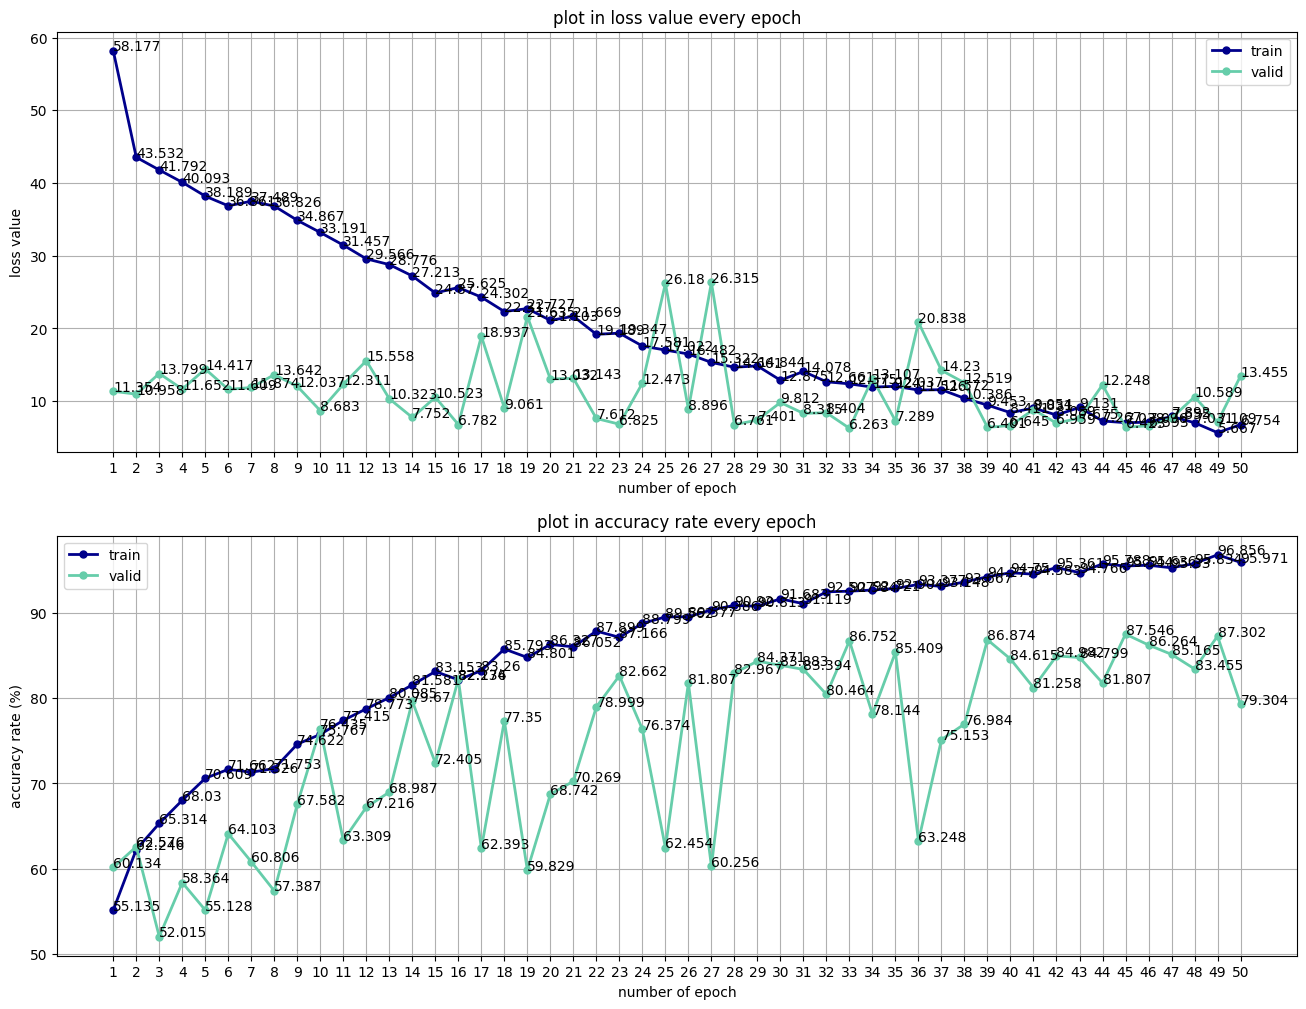

In [ ]:
fig, (axes1, axes2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
# 1つ目のグラフの中身を定義(損失関数の値)
for i, y_datas1 in enumerate(y_datas1_list):
    axes1.plot(x_datas, y_datas1, c=label2color[i], label=labels[i], marker="o", markersize=5, linestyle="solid", linewidth=2)
    for j in range(len(y_datas1)):
        axes1.annotate(text=round(y_datas1[j], 3), xy=(x_datas[j], y_datas1[j]))
axes1.legend()
axes1.set_title("plot in loss value every epoch")
axes1.set_xlabel("number of epoch")
axes1.set_ylabel("loss value")
axes1.set_xticks(ticks=x_datas)
axes1.grid(True)
# 2つ目のグラフの中身を定義(正答率)
for i, y_datas2 in enumerate(y_datas2_list):
    axes2.plot(x_datas, y_datas2, c=label2color[i], label=labels[i], marker="o", markersize=5, linestyle="solid", linewidth=2)
    for j in range(len(y_datas2)):
        axes2.annotate(text=round(y_datas2[j], 3), xy=(x_datas[j], y_datas2[j]))
axes2.legend()
axes2.set_title("plot in accuracy rate every epoch")
axes2.set_xlabel("number of epoch")
axes2.set_ylabel("accuracy rate (%)")
axes2.set_xticks(ticks=x_datas)
axes2.grid(True)
# グラフを表示
plt.show()

**検証**

In [ ]:
if os.path.isfile("./FineTuning_ResNet50.model"):
    nn_model.load_state_dict(torch.load("./FineTuning_ResNet50.model"))
nn_model.eval()
with torch.no_grad():
    valid_data_num_total = 0
    accuracy_num_total = 0
    for valid_image_tensor_minibatch, valid_label_tensor_minibatch in valid_dataset_dataloader:
        valid_image_tensor_minibatch = valid_image_tensor_minibatch.to(device)
        valid_label_tensor_minibatch = valid_label_tensor_minibatch.to(device)
        predict = nn_model(in_data=valid_image_tensor_minibatch)
        predict_softmax = torch.nn.functional.softmax(input=predict, dim=1)
        predict_softmax_argmax = torch.argmax(input=predict_softmax, dim=1)
        valid_data_num = len(valid_label_tensor_minibatch)
        valid_data_num_total = valid_data_num_total + valid_data_num
        accuracy_num = (predict_softmax_argmax == valid_label_tensor_minibatch).sum().item()
        accuracy_num_total = accuracy_num_total + accuracy_num
    accuracy_rate = accuracy_num_total / valid_data_num_total * 100
    print("検証データ数：{a}".format(a=valid_data_num_total))
    print("正解数：{a}".format(a=accuracy_num_total))
    print("正解率は{a}%".format(a=round(accuracy_rate, 5)))